## Gradient Descent Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score

In [27]:
class GD_Model:
    #--- the model can handle multivariate data 
    #--- but plotting is not yet configured for multivariate data so leave it false for now
    def __init__(self):
        self.theta_update = 0
        self.velocity_update = 0
        self.theta_history = []
        self.cost_history = []
        self.gradient_history = []
        self.hypoth_history = []
        
    def clean(self):
        self.theta_update = 0
        self.velocity_update = 0
        self.theta_history.clear()
        self.cost_history.clear()
        self.gradient_history.clear()
        self.hypoth_history.clear()
        
    def hypoth_f(self,X,theta):
        hypo = X.dot(theta)
        self.hypoth_history.append(hypo)
        return hypo
    
    def cost_f(self,hypoth,y):
        cost = np.sum((hypoth - y)**2) * 1/ (2 * y.shape[0])
        self.cost_history.append(cost)
        return cost
    def gradient_f(self,hypoth,y,X):
        '''
        Parameters
        ----------
        hypoth : h(theta) = theta0 * X0 + theta1 * X1 + theta2...
        y : Actual values of target y.
        X : input values of x.
        Returns
        -------
        grad(J(theta0,theta1,...)).
        '''
        grad = X.T.dot(hypoth - y) * 1 / y.shape[0]
        self.gradient_history.append(grad)
        return grad
    
    def update_technique(self,X,y,thetaV,alpha,gamma,technique='standard'):
        if technique == 'standard':
            '''
            theta = theta - alpha * gradient
            update_term = alpha * gradient
            '''
            hypoth = self.hypoth_f(X,thetaV)
            cost = self.cost_f(hypoth,y)
            gradient = self.gradient_f(hypoth,y,X)
            self.theta_update =  alpha * gradient

        if technique == 'momentum':
            '''
            v = gamma * v + alpha * grad
            theta = theta - v
            update_term = v
            '''
            hypoth = self.hypoth_f(X,thetaV)
            cost = self.cost_f(hypoth,y)
            gradient = self.gradient_f(hypoth,y,X)
            self.velocity_update = gamma * self.velocity_update + alpha * gradient 
            self.theta_update = self.velocity_update
        
        if technique == 'nestrov':
            '''
                Wtemp = Wt - gamma * Vt
                W = ((W - gamma * Vt)) - alpha * gradient(J(Wtemp))
                Vt = gamma Vt + alpha gradient(J(Wtemp))
                
                update_term =  gamma * Vt + alpha * gradient(J(Wtemp))
            '''
            thetaVTemp = thetaV - gamma * self.velocity_update
    
            hypoth_temp = self.hypoth_f(X,thetaVTemp)
            cost_temp = self.cost_f(hypoth_temp,y)
            gradient_temp = self.gradient_f(hypoth_temp,y,X)
            
            self.theta_update = gamma * self.velocity_update + alpha * gradient_temp 
            self.velocity_update = gamma * self.velocity_update + alpha * gradient_temp 
        self.theta_history.append(thetaV)
    def check_convergence(self,epsilon):
        if (np.linalg.norm(self.gradient_history[-1],2) < epsilon):
            return True
        elif len(self.cost_history )> 1:
            if abs(self.cost_history[-1]-self.cost_history[-2]) < epsilon:
                return True
        return False
    
    def fit(self,X,y,algorithm = 'vanilla',method = 'standard', alpha=0.01,gamma=0.9,max_iterations = 100,n_batch=1,plot_sum = False,plot_det = False,epsilon= 1e-3):
        '''
        Parameters
        ----------
        X : input Feauters [x0 | x1 | x2 | ...].
        y : Target y.
        algorithm : ['vanilla','mini_batch','stochastic'].
        method of convergence : ['standard' , 'momentum' , 'nestrov'].
        alpha : learning rate.
        gamma : history dependence rate.
        max_iterations : The default is 1000.
        n_batch : number of batches if 1 then all data is evaluated for every parameter.
        plot summary :  optional The default is False.
        plot details : loss function behaviour
        Returns
        -------
        '''
        self.clean()
        thetaV = np.zeros(X.shape[1])   #theta vector with X columns shape.
 
        if algorithm == 'vanilla' :
            for i in range(max_iterations):
                self.update_technique(X,y,thetaV,alpha,gamma,technique=method)
                thetaV = thetaV - self.theta_update
                if self.check_convergence(epsilon): break
            
        if algorithm == 'mini_batch' :
            items_per_batch = y.shape[0] // n_batch # use selected number of observation to calculate cost.
            for i in range(max_iterations):
                for K in range(0,y.shape[0],items_per_batch):
                    X_m = X[K:K+items_per_batch]
                    y_m = y[K:K+items_per_batch]
                self.update_technique(X_m,y_m ,thetaV,alpha,gamma,technique=method)
                thetaV = thetaV - self.theta_update
                if self.check_convergence(epsilon): break
            
        if algorithm == 'stochastic' :
            items_per_batch = 1  
            for i in range(max_iterations):
                for K in range(0,y.shape[0],items_per_batch):
                    X_m = X[K:K+items_per_batch]
                    y_m = y[K:K+items_per_batch]
                self.update_technique(X_m,y_m ,thetaV,alpha,gamma,technique=method)
                thetaV = thetaV - self.theta_update
                if self.check_convergence(epsilon): break
        if plot_sum :
            acc = r2_score(y,X.dot(thetaV))*100
            self.plot_summary(X , y ,thetaV, title = f'Algorithm : {algorithm} ,Technique : {method} \n Iterations : {len(self.theta_history)} ,Learning Rate : {alpha} , gamma : {gamma} \n Accuracy : {acc} %' )
        if plot_det:
            self.plot_details(X , y)
            
    def plot_summary(self,X,y,theta_optimum,title):
        plt.clf()
        plt.title(title)
        plt.plot(X[:,1:],X.dot(theta_optimum),c='black',alpha = 1)
        plt.scatter(X[:,1:],y,c=y, cmap=plt.plasma())
        plt.grid()
        plt.show()
        
    def plot_details(self,X,y):
        plt.clf()
        fig , ((ax0,ax1),(ax2,ax3)) = plt.subplots(2,2,figsize=(12,8))
        ax0.plot(self.cost_history,'b--',marker='x',label='loss',alpha=0.3)
        ax0.set_ylabel('Cost_Func')
        ax0.set_xlabel('iterations')
       
        theta_history_vec = np.array(self.theta_history)
        
        ax1.plot(theta_history_vec[:,0],self.cost_history,'r--',marker='x',alpha=0.3)

        ax1.set_ylabel('Cost_Func')
        ax1.set_xlabel('Theta_0')
        
        ax2.plot(theta_history_vec[:,1],self.cost_history,'r--',marker='x',alpha=0.3)

        ax2.set_ylabel('Cost_Func')
        ax2.set_xlabel('Theta_1')
        
        
        for theta_i in self.theta_history:
            ax3.plot(X[:,1:],X.dot(theta_i),alpha = 0.15)
        ax3.scatter(X[:,1:],y, cmap=plt.plasma())
        ax3.grid()

        plt.show()

## Example 1

In [12]:
x = np.array([2.9000001 , 6.69999981, 4.9000001 , 7.9000001 , 9.80000019,6.9000001 , 6.0999999 , 6.19999981, 6., 5.0999999 ,
       4.69999981, 4.4000001 , 5.80000019])

y = np.array([4., 7.4000001 , 5., 7.19999981, 7.9000001 ,6.0999999 , 6., 5.80000019, 5.19999981, 4.19999981,
       4., 4.4000001 , 5.19999981])
X = np.vstack((np.ones((x.shape[0]))  ,x)).T ## append column of ones and Transpose to Column vectors

In [13]:
gd_model = GD_Model()

(2,)


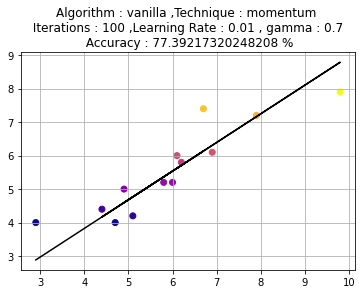

<Figure size 432x288 with 0 Axes>

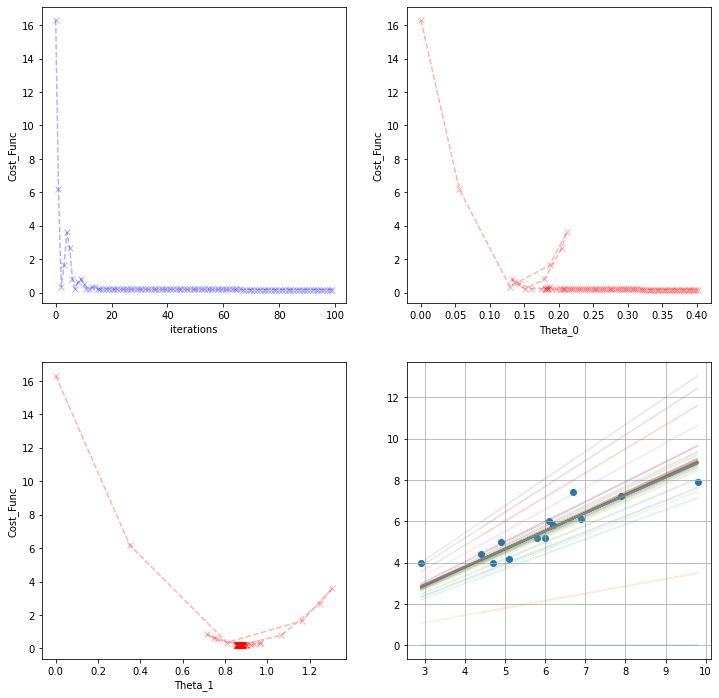

In [16]:
gd_model.fit(X,y,algorithm='vanilla',method='momentum',alpha=0.01,gamma = 0.7,epsilon=1e-4,max_iterations=100,n_batch=1,plot_sum=True,plot_det=True)

(2,)


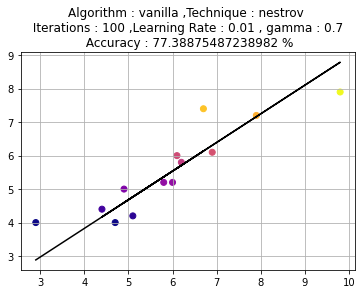

<Figure size 432x288 with 0 Axes>

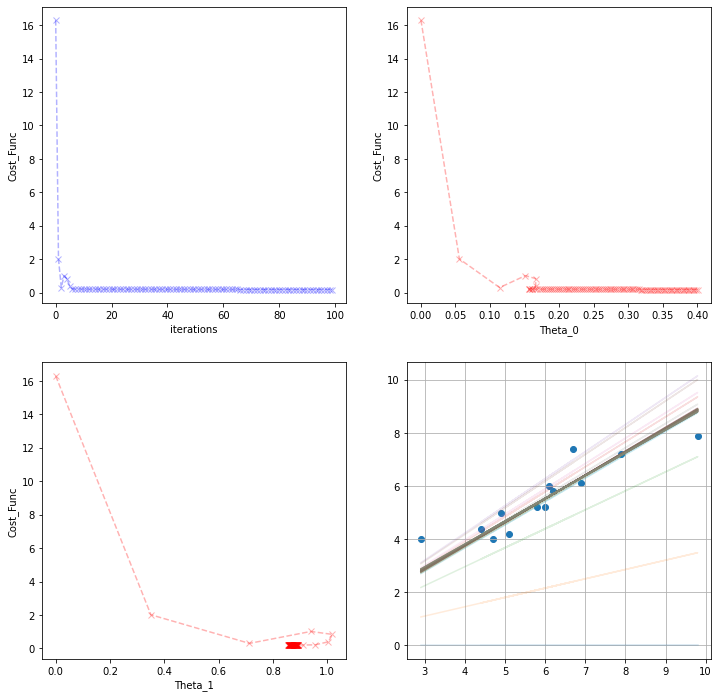

In [17]:
gd_model.fit(X,y,algorithm='vanilla',method='nestrov',alpha=0.01,gamma = 0.7,epsilon=1e-4,max_iterations=100,n_batch=1,plot_sum=True,plot_det=True)

(2,)


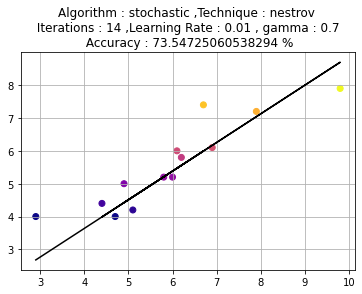

<Figure size 432x288 with 0 Axes>

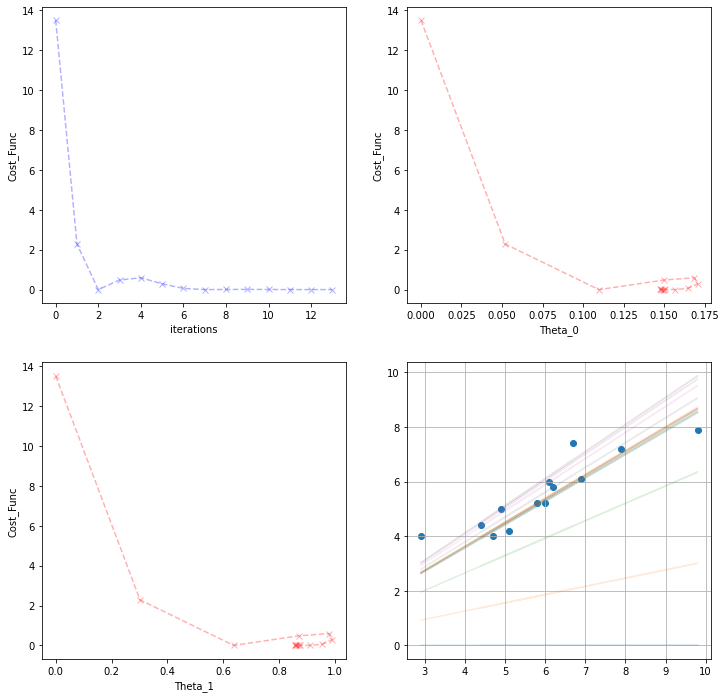

In [18]:
gd_model.fit(X,y,algorithm='stochastic',method='nestrov',alpha=0.01,gamma = 0.7,epsilon=1e-4,max_iterations=100,n_batch=1,plot_sum=True,plot_det=True)

## MultiVariate

In [21]:
df = pd.read_csv('MultipleLR.csv', header=None)
x_multiV = df.loc[:,0:2].to_numpy()
y_multiV = df.loc[:,3].to_numpy()
    
X =  np.hstack( (np.ones((x_multiV.shape[0],1)),x_multiV) )  

In [33]:
gd_model.fit(X,y_multiV,algorithm='vanilla',method='standard',alpha=0.0001,gamma = 0.2,epsilon=1e-4,max_iterations=1000,n_batch=1,plot_sum=False,plot_det=False);

(4,)


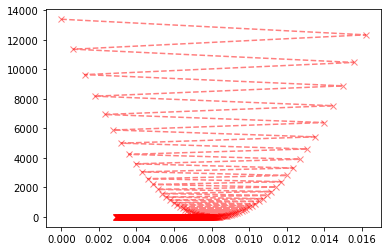

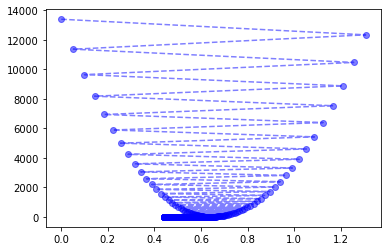

In [36]:
cost_history = gd_model.cost_history
theta_history = gd_model.theta_history
theta_history_vec = np.array(theta_history)
plt.plot(theta_history_vec[:,0],cost_history,'r--',marker='x',alpha=0.5)
plt.show() 
plt.plot(theta_history_vec[:,1], cost_history,'b--',marker='o',alpha=0.5)
plt.show()   

In [38]:
gd_model.fit(X,y_multiV,algorithm='vanilla',method='nestrov',alpha=0.0001,gamma = 0.2,epsilon=1e-4,max_iterations=1000,n_batch=1,plot_sum=False,plot_det=False);

(4,)


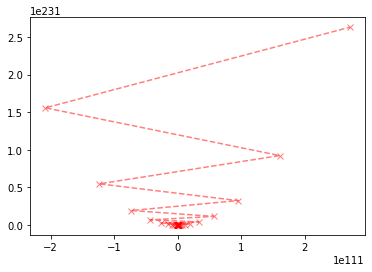

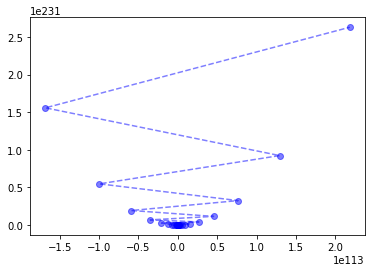

In [39]:
cost_history = gd_model.cost_history
theta_history = gd_model.theta_history
theta_history_vec = np.array(theta_history)
plt.plot(theta_history_vec[:,0],cost_history,'r--',marker='x',alpha=0.5)
plt.show() 
plt.plot(theta_history_vec[:,1], cost_history,'b--',marker='o',alpha=0.5)
plt.show()   